<a href="https://colab.research.google.com/github/mashnoor3/data-science-portfolio/blob/main/Google_Play_Store_Apps_Exploratory_Data_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Google Play Store Apps - Explortatory Data Analysis
In this analysis, I explore apps on the Google Ploy Store, as well as their user reviews. The app store and user reviews datasets are taken from Kaggle, and have been uploaded [here](https://console.cloud.google.com/storage/browser/mashnoor-data-science-portfolio;tab=objects). 

Throughout our analysis I try to answer the questions of which apps are most popular by looking at different information like price of the app, paid vs free, categories, etc.

In [ ]:
# Import packages
import pandas as pd
import plotly
import plotly.express as px
import plotly.io as pio
pio.renderers.default = 'colab'
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
sns.set_style("darkgrid")
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Install dependendencies to connect to Google Cloud Storage
!pip -q install fsspec # File-system specification
!pip -q install gcsfs # Convenient Filesystem interface over GCS

# Review data for duplicates and missing data

Let's load the datasets from GCS into dataframe, and deal with any missing and duplicate data.

There are a lot of duplicate rows. Let's remove these before we start our analysis. For missing data, the dataset for apps is only missing data in Rating or Content Rating columns. This is fine because a user may decide not to leave reviews. We can proceed without doing anything for this. 

In [ ]:
gs_bucket = 'gs://mashnoor-data-science-portfolio/'

apps = pd.read_csv(gs_bucket + 'google_playstore_apps.csv', encoding='utf-8')
reviews = pd.read_csv(gs_bucket + 'google_playstore_user_reviews.csv', encoding='utf-8')

display(apps.head())

print('\nNumber of missing data for each column:\n{}'.format(apps.isna().sum()))
print('\nNumber of duplicate rows: {} \n'.format(apps.duplicated().sum()))

apps = apps.drop_duplicates()
print(apps.info())

# Print the total number of apps
print('Total number of apps in the dataset = ', apps.shape[0])

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up



Number of missing data for each column:
App                  0
Category             0
Rating            1474
Reviews              0
Size                 0
Installs             0
Type                 1
Price                0
Content Rating       1
Genres               0
Last Updated         0
Current Ver          8
Android Ver          3
dtype: int64

Number of duplicate rows: 483 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10358 entries, 0 to 10840
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   App             10358 non-null  object 
 1   Category        10358 non-null  object 
 2   Rating          8893 non-null   float64
 3   Reviews         10358 non-null  object 
 4   Size            10358 non-null  object 
 5   Installs        10358 non-null  object 
 6   Type            10357 non-null  object 
 7   Price           10358 non-null  object 
 8   Content Rating  10357 non-null  object 
 9   Genre

# Data Cleaning 

The four features that we are interested are *Installs, Size, Rating and Price*. Looking at the type of each column, above, we can see that *Installs, Price, Size* are columns are of type object and not int64 or float64 as expected. This is because the column contains some characters more than just [0,9] digits. Ideally, need these columns to be converted to numeric.

Therefore let's clean the apps data so it's ready for analysis next. Specifically, special characters like (, $ +) needs to be removed from Installs and Price columns, and then converted to numerical data type.

When trying to convert the Installs and Price columns after removing the special characters, we see that we still are not able to because one of the columsn have the string 'Free'. Digging futther this is the "Life Made WI-Fi Touchscreen Photo Frame" app. Let's remove this row. 

When observing the *Size* column, we see that there are 1526 apps with a size value of "Varies with device". Since we have no idea of what this value should be, we can think of this as missing values. So what to do with these missing values? Since 1526 is roughly 15% of our dataset obervation, we can still drop these rows (observations) without significantly affecting our dataset. Thus we will drop these rows. Next, we need to get the *Size* values to a common metric, since some are in KB and others in MB. 

In [ ]:
# Remove row with incorrect data
# Remove rows that have a value of "Free" for Installs 
to_drop_index = apps[apps['Installs']=='Free'].index
apps.drop(to_drop_index, inplace=True)

# Remove rows that have a value of "Varies with device" for Size
to_drop_index = apps[apps['Size']=='Varies with device'].index
apps.drop(to_drop_index, inplace=True)

# List of characters to remove
chars_to_remove = [',', '$', '+']
# List of column names to clean
cols_to_clean = ['Installs', 'Price']

# Loop for each column in cols_to_clean
for col in cols_to_clean:
    # Loop for each char in chars_to_remove
    for char in chars_to_remove:
        # Replace the character with an empty string
        apps[col] = apps[col].apply(lambda x: x.replace(char, ''))
    # Convert col to float data type
    apps[col] = apps[col].astype(float)

# Convert size column values to MB, drop M, k and convert to float 
def size_to_float_MB(size): 
  if ('M' in size):
    size = float(size.replace('M', ''))
  elif ('k' in size):
    size = float(size.replace('k', ''))/1000
  return size

apps['Size']=apps['Size'].apply(size_to_float_MB)
apps['Size'] = apps[col].astype(float)
apps = apps.rename(columns={'Size':'Size (MB)'})

,App,Category,Rating,Reviews,Size (MB),Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,0.0,10000.0,Free,0.0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,0.0,500000.0,Free,0.0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,0.0,5000000.0,Free,0.0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,0.0,50000000.0,Free,0.0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,0.0,100000.0,Free,0.0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up


# Exploring app categories

With more than 1 billion active users in 190 countries around the world, Google Play continues to be an important distribution platform to build a global audience. For businesses to get their apps in front of users, it's important to make them more quickly and easily discoverable on Google Play. To improve the overall search experience, Google has introduced the concept of grouping apps into categories.

This brings us to the following questions:

- Which category has the highest share of (active) apps in the market?
- Is any specific category dominating the market?
- Which categories have the fewest number of apps?

We see that there are 33 unique app categories present in our dataset. *Family and Game* apps have the highest market prevalence. 
*Tools, Business and Medical* apps are also at the top.

In [ ]:
# Print the total number of unique categories
num_categories = len(apps['Category'].value_counts())
# num_categories = apps['Category'].nunique()
print('Number of categories = ', num_categories)

# Count the number of apps in each 'Category'. Sort in descending order depending on number of apps in each category
num_apps_in_category = apps['Category'].value_counts().sort_values(ascending=False)

fig = px.bar(x=num_apps_in_category.index, 
             y=num_apps_in_category.values,
             labels={'x':'Categories', 'y':'Number of apps'})
fig.update_layout(title_text='Number of apps in each category on Google Playstore'
                  ,title_x=0.5)
fig.show()

Number of categories =  33


# Distribution of app ratings

Now that we explored the category distribution, let's see how all these apps perform on an average. App ratings (on a scale of 1 to 5) impact the discoverability, conversion of apps as well as the company's overall brand image. Ratings are a key performance indicator of an app.

From the analysis below, we can see that the average volume of ratings across all app categories is 4.17. The histogram plot is skewed to the right indicating that the majority of the apps are highly rated with only a few exceptions in the low-rated apps.

In [258]:
# Average rating of apps
avg_app_rating = apps['Rating'].mean()
print('Average app rating = ', avg_app_rating)

# # Distribution of apps according to their ratings
fig = px.histogram(apps, x="Rating")

# Adding line for the average
fig.add_trace(
        go.Scatter(
        x=[avg_app_rating, avg_app_rating],
        y=[0, 1000],
        mode="lines",        
        showlegend=True,
        name='Average app rating'))

fig.update_layout(title_text='Distribution of app ratings'
                  ,title_x=0.5)
fig.show()

Average app rating =  4.171309267241382


# Size and price of an app

Now let's examine app size and app price. For size, if the mobile app is too large, it may be difficult and/or expensive for users to download. Lengthy download times could turn users off before they even experience your mobile app. Plus, each user's device has a finite amount of disk space. For price, some users expect their apps to be free or inexpensive. These problems compound if the developing world is part of your target market; especially due to internet speeds, earning power and exchange rates.

How can we effectively come up with strategies to size and price our app?

- Does the size of an app affect its rating?
- Do users really care about system-heavy apps or do they prefer light-weighted apps?
- Does the price of an app affect its rating?
- Do users always prefer free apps over paid apps?

Plotting the Rating against Size we see that the majority of top rated apps (rating over 4) range from 2 MB to 20 MB. 

Next, looking at Rating against Price we see that majority of apps are priced under $10.

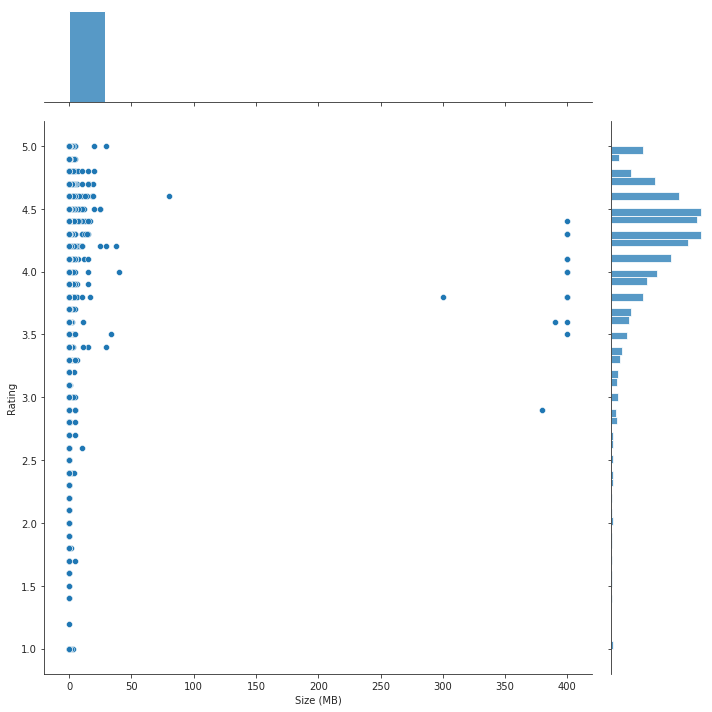

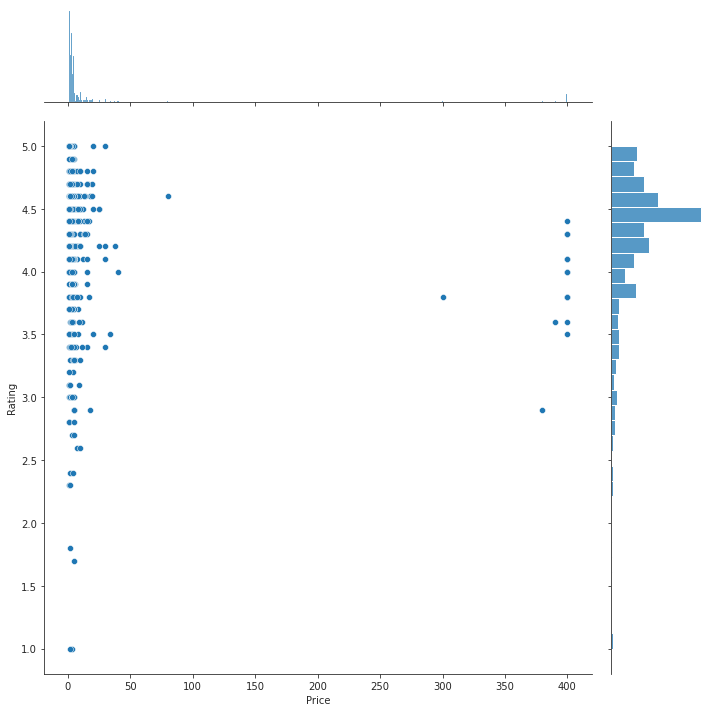

In [246]:
# Select rows where both 'Rating' and 'Size' values are present (ie. the two values are not null)
apps_with_size_and_rating_present = apps[(~apps['Rating'].isnull()) & (~apps['Size (MB)'].isnull())]
# print(apps_with_size_and_rating_present.head())

# Subset for categories with at least 250 apps
large_categories = apps_with_size_and_rating_present.groupby(['Category']).filter(lambda x: len(x) >= 250)

# Select apps whose 'Type' is 'Paid'
paid_apps = apps_with_size_and_rating_present[apps_with_size_and_rating_present['Type']=='Paid']

# Plot size vs. rating
sns.jointplot(x = large_categories['Size (MB)'], y = large_categories['Rating'], height=10)
# Plot price vs. rating
sns.jointplot(x = paid_apps['Price'], y = paid_apps['Rating'], height=10)

# Relation between app category and app price

Different factors affect the price of an app, and different categories demand different price ranges. Common or simple apps seemed to be free, and highly specialized apps are the most expensive, for example medical apps are on the high side. 

In the plot below we can see that *Medical* and *Family* apps are the most expensive. Some medical apps extend even up to \$80. All game apps are priced below \$20.

Looking at the plot, we can also see that there are outliers in *Family, Lifestyle, and Finance* categories. Where there are apps priced at \$400! 

,Category,App,Price
4197,FAMILY,most expensive app (H),399.99
4362,LIFESTYLE,💎 I'm rich,399.99
4367,LIFESTYLE,I'm Rich - Trump Edition,400.00
5351,LIFESTYLE,I am rich,399.99
5354,FAMILY,I am Rich Plus,399.99
5355,LIFESTYLE,I am rich VIP,299.99
5356,FINANCE,I Am Rich Premium,399.99
5357,LIFESTYLE,I am extremely Rich,379.99
5358,FINANCE,I am Rich!,399.99
5359,FINANCE,I am rich(premium),399.99


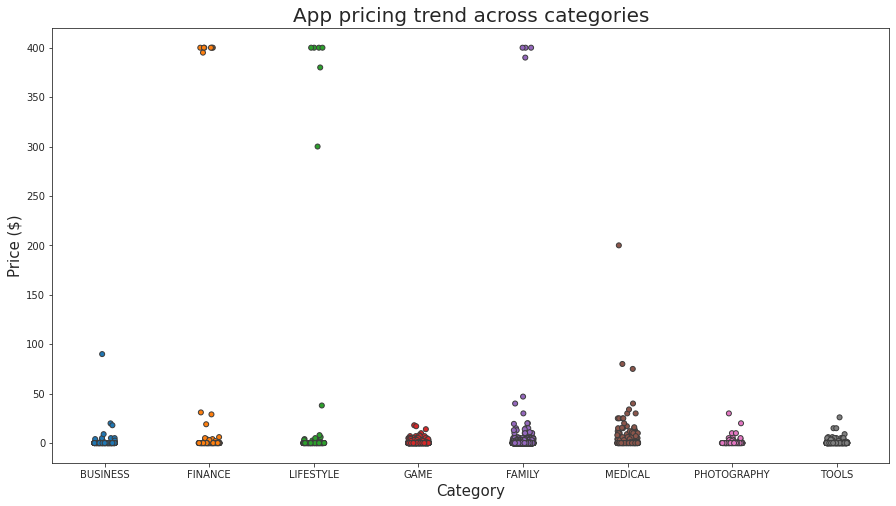

In [252]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 8)

# Select a few popular app categories
popular_app_cats = apps[apps.Category.isin(['GAME', 'FAMILY', 'PHOTOGRAPHY',
                                            'MEDICAL', 'TOOLS', 'FINANCE',
                                            'LIFESTYLE','BUSINESS'])]

# Examine the price trend by plotting Price vs Category
ax = sns.stripplot(x = popular_app_cats['Category'], y = popular_app_cats['Price'], jitter=True, linewidth=1)
ax.set_title('App pricing trend across categories', fontsize=20)
ax.set_ylabel('Price ($)', fontsize=15)
ax.set_xlabel('Category', fontsize=15)


# Apps whose Price is greater than 200
apps_above_200 = apps[apps['Price']>200]
apps_above_200[['Category', 'App', 'Price']]

# Filtering out outliers - "junk" apps

Let's filter out the ouliying junk apps that we discovered. These are apps that don't really have a purpose, and just priced high for no positive reason. Let's filter out the junk apps and re-do the visualization.

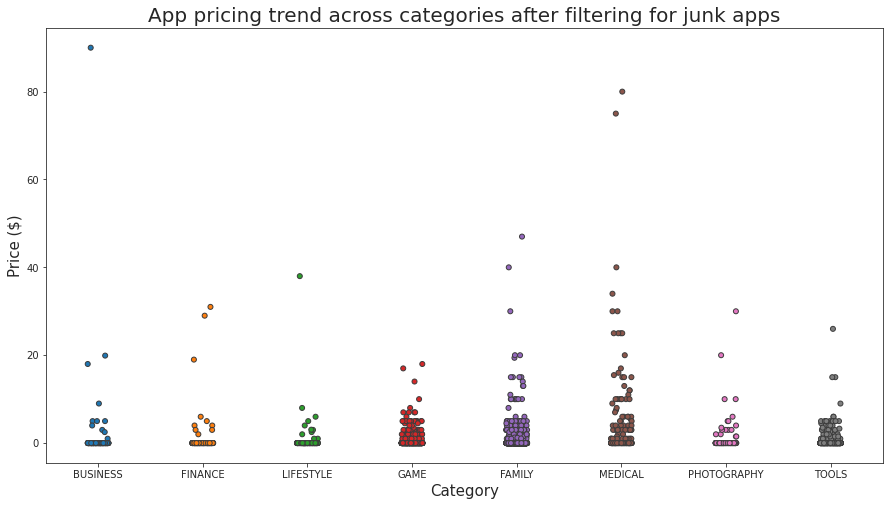

In [255]:
# Select apps priced below $100
apps_under_100 = popular_app_cats[popular_app_cats['Price']<100]

fig, ax = plt.subplots()
fig.set_size_inches(15, 8)

# Examine price vs category with the authentic apps (apps_under_100)
ax = sns.stripplot(x = apps_under_100['Category'], y = apps_under_100['Price'], jitter = True, linewidth = 1)
ax.set_title('App pricing trend across categories after filtering for junk apps', fontsize=20)
ax.set_ylabel('Price ($)', fontsize=15)
ax.set_xlabel('Category', fontsize=15)
plt.show()

# Popularity of paid apps vs free apps

For apps in the Play Store today, there are five types of pricing strategies: free, freemium, paid, paymium, and subscription. Let's focus on free and paid apps only. Some characteristics of free apps are:

- Free to download.
- Main source of income often comes from advertisements.
- Often created by companies that have other products and the app serves as an extension of those products.
- Can serve as a tool for customer retention, communication, and customer service.

Some characteristics of paid apps are:

- Users are asked to pay once for the app to download and use it.
- The user can't really get a feel for the app before buying it.

Are paid apps installed as much as free apps? It turns out that paid apps have a relatively lower number of installs than free apps, however the difference is not that big! 

In [227]:
trace0 = go.Box(
    # Data for paid apps
    y = apps[apps['Type'] == 'Paid']['Installs'],
    name = 'Paid'
)

trace1 = go.Box(
    # Data for free apps
    y = apps[apps['Type'] == 'Free']['Installs'],
    name = 'Free'
)

layout = go.Layout(
    title = "Number of downloads of paid apps vs. free apps",
    yaxis = dict(title = "Log number of downloads",
                type = 'log',
                autorange = True)
)

# Add trace0 and trace1 to a list for plotting
data = [trace0, trace1]
plotly.offline.iplot({'data': data, 'layout': layout})

# Sentiment analysis of user reviews
Mining user review data to determine how people feel about your product, brand, or service can be done using a technique called sentiment analysis. User reviews for apps can be analyzed to identify if the mood is positive, negative or neutral about that app. For example, positive words in an app review might include words such as 'amazing', 'friendly', 'good', 'great', and 'love'. Negative words might be words like 'malware', 'hate', 'problem', 'refund', and 'incompetent'.

By plotting sentiment polarity scores of user reviews for paid and free apps, we observe that free apps receive a lot of harsh comments, as indicated by the outliers on the negative y-axis. Reviews for paid apps appear never to be extremely negative. This may indicate something about app quality, i.e., paid apps being of higher quality than free apps on average. The median polarity score for paid apps is a little higher than free apps, thereby syncing with our previous observation.

In this notebook, we analyzed over ten thousand apps from the Google Play Store. These findings can be used to make decisions when creating an app.

,App,Translated_Review,Sentiment,Sentiment_Polarity,Sentiment_Subjectivity
0,10 Best Foods for You,I like eat delicious food. That's I'm cooking ...,Positive,1.00,0.533333
1,10 Best Foods for You,This help eating healthy exercise regular basis,Positive,0.25,0.288462
2,10 Best Foods for You,NaN,NaN,NaN,NaN
3,10 Best Foods for You,Works great especially going grocery store,Positive,0.40,0.875000
4,10 Best Foods for You,Best idea us,Positive,1.00,0.300000


,App,Category,Rating,Reviews,Size (MB),Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver,Translated_Review,Sentiment,Sentiment_Polarity,Sentiment_Subjectivity
0,Coloring book moana,ART_AND_DESIGN,3.9,967,0.0,500000.0,Free,0.0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up,A kid's excessive ads. The types ads allowed a...,Negative,-0.250,1.000000
1,Coloring book moana,ART_AND_DESIGN,3.9,967,0.0,500000.0,Free,0.0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up,It bad >:(,Negative,-0.725,0.833333
2,Coloring book moana,ART_AND_DESIGN,3.9,967,0.0,500000.0,Free,0.0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up,like,Neutral,0.000,0.000000
3,Coloring book moana,ART_AND_DESIGN,3.9,967,0.0,500000.0,Free,0.0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up,NaN,NaN,NaN,NaN
4,Coloring book moana,ART_AND_DESIGN,3.9,967,0.0,500000.0,Free,0.0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up,I love colors inspyering,Positive,0.500,0.600000


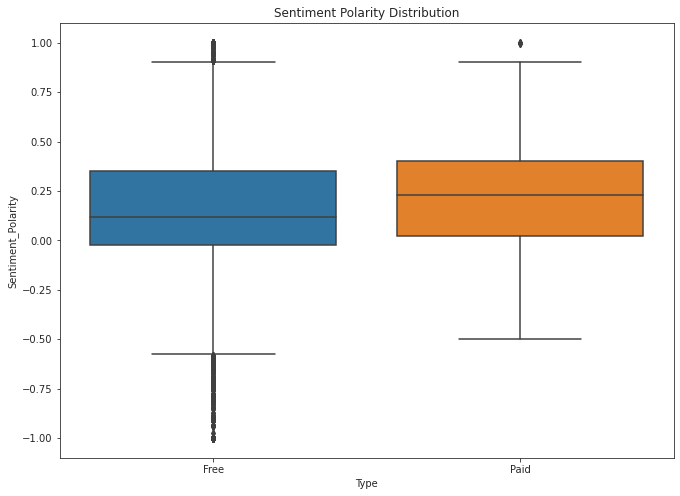

In [262]:
# Join the two dataframes
display(reviews.head())
merged_df = pd.merge(apps, reviews, on='App')
display(merged_df.head())

# Drop NA values from Sentiment and Review columns
merged_df = merged_df.dropna(subset = ['Sentiment', 'Translated_Review'])

sns.set_style('ticks')
fig, ax = plt.subplots()
fig.set_size_inches(11, 8)

# User review sentiment polarity for paid vs. free apps
ax = sns.boxplot(x = merged_df['Type'], y = merged_df['Sentiment_Polarity'])
ax.set_title('Sentiment Polarity Distribution')
plt.show()